In [1]:
!pip install opencv-python
import pyvista as pv
import numpy as np
import os
import random
import math
import os
import zipfile
import shutil
import re
import random
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2
import shutil

Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '19'
Showing a PyVista plot with the random cubemap as background.


2025-08-08 07:42:01.024 (   0.760s) [    7608287DB740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/dima/miniconda3/envs/aiijcenv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


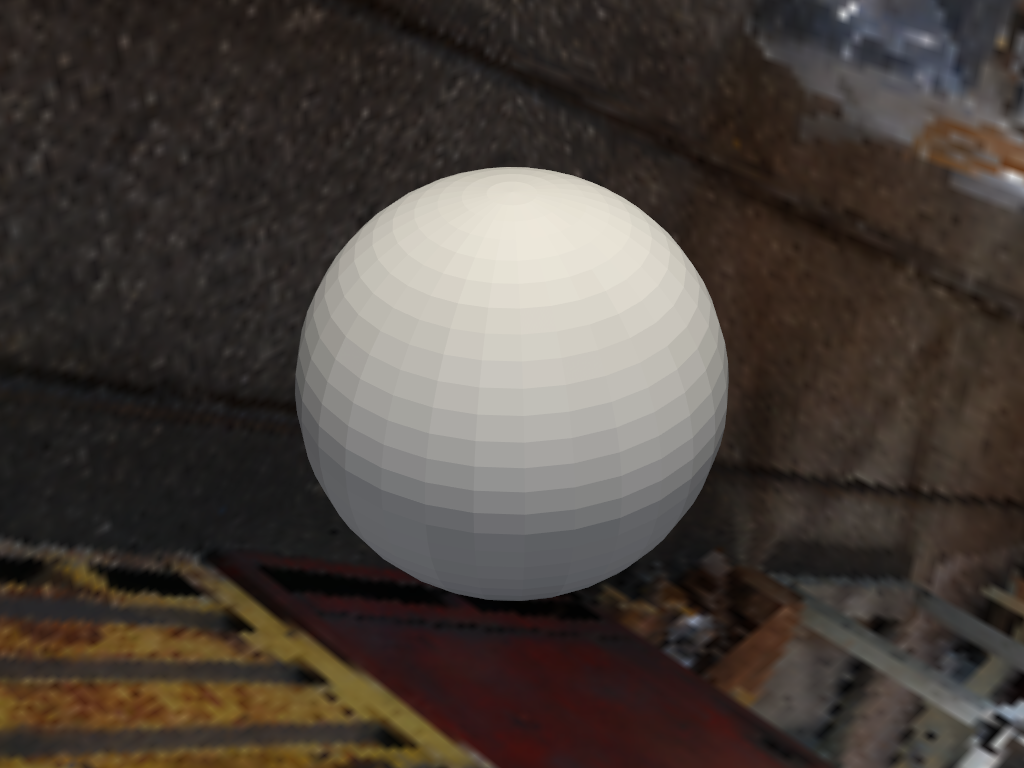

In [2]:

def unpack_cubemaps(data_dir="cubemaps"):
    """
    Unpacks .zip archives from a directory into structured subfolders.

    Each archive is unpacked into a subdirectory named after a number 'n'.
    The files inside are renamed according to the pattern: n_[pos/neg][x/y/z].png.
    This function is idempotent, meaning it will not re-unpack archives if the
    target directories already exist.

    Args:
        data_dir (str): The path to the directory containing both the .zip files
                        and where the output folders will be created.
    """
    print(f"Checking for archives to unpack in '{data_dir}'...")

    # Ensure the base directory exists
    if not os.path.exists(data_dir):
        print(f"Directory '{data_dir}' not found. Creating it.")
        os.makedirs(data_dir)

    # --- Main loop to iterate through files in the directory ---
    for filename in os.listdir(data_dir):
        if not filename.endswith(".zip"):
            continue

        # --- Determine the number 'n' from the archive's filename ---
        if filename == "Standard-Cube-Map.zip":
            n = 0
        else:
            # Use a regular expression to find the number in parentheses, e.g., (1), (12)
            match = re.search(r"\((\d+)\)", filename)
            if match:
                n = int(match.group(1))
            else:
                continue  # Skip .zip files that don't match the expected naming pattern

        # --- Create the target directory for the current cubemap ---
        new_dir_path = os.path.join(data_dir, str(n))

        # --- Unpack only if the directory doesn't already exist ---
        if os.path.exists(new_dir_path):
            # print(f"Directory '{new_dir_path}' already exists. Skipping unpack.")
            continue

        print(f"Unpacking '{filename}' to '{new_dir_path}'...")
        os.makedirs(new_dir_path)

        # --- Unpack and rename files ---
        zip_path = os.path.join(data_dir, filename)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            for member in zip_ref.namelist():
                original_name = os.path.basename(member)

                # Skip directories or non-PNG files within the archive
                if not original_name or not original_name.endswith(".png"):
                    continue

                # Logic to determine the new filename
                prefix_char = original_name[0]  # 'n' or 'p'
                axis_char = original_name[1]  # 'x', 'y', or 'z'
                side = "neg" if prefix_char == "n" else "pos"

                # Format the new name: e.g., "2_posx.png"
                new_name = f"{n}_{side}{axis_char}.png"
                target_path = os.path.join(new_dir_path, new_name)

                # Extract the file and save it with the new name
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    shutil.copyfileobj(source, target)

    print("Unpacking process finished.")


def get_random_pyvista_cubemap(data_dir="cubemaps"):
    """
    Selects a random cubemap from the data directory and returns it as a PyVista object.

    This function first ensures all cubemaps are unpacked. Then, it randomly
    chooses one of the numbered subdirectories and loads the corresponding
    cubemap textures using pyvista.

    Args:
        data_dir (str): The directory containing the numbered cubemap folders.

    Returns:
        pyvista.Texture: A PyVista cubemap texture object, or None if no
                         cubemaps are found or PyVista is not installed.
    """
    if pv is None:
        print(
            "Error: PyVista library is not installed. Please install it with 'pip install pyvista'"
        )
        return None

    # Step 1: Ensure all archives are unpacked into their respective folders.
    unpack_cubemaps(data_dir)

    # Step 2: Find all valid, numbered cubemap directories.
    try:
        subdirs = [
            d
            for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, d)) and d.isdigit()
        ]
    except FileNotFoundError:
        print(f"Error: Data directory '{data_dir}' not found.")
        return None

    if not subdirs:
        print(f"Error: No numbered cubemap directories found in '{data_dir}'.")
        return None

    # Step 3: Choose a random cubemap directory.
    random_n = random.choice(subdirs)
    print(f"Selected random cubemap: '{random_n}'")

    # Step 4: Define the parameters for PyVista.
    # The path to the directory containing the 6 images.
    cubemap_path = os.path.join(data_dir, random_n)
    # The prefix for the image files, e.g., "2_". PyVista will append "posx", "negy", etc.
    cubemap_prefix = f"{random_n}_"
    # The file extension.
    cubemap_ext = ".png"

    # Step 5: Create and return the PyVista cubemap object.
    return pv.cubemap(cubemap_path, cubemap_prefix, cubemap_ext)


# --- Example Usage ---
if __name__ == "__main__":
    # Define the directory where your 'Standard-Cube-Map.zip', 'Cube-Map(1).zip', etc. are located.
    CUBEMAPS_DIRECTORY = "cubemaps"

    # Get a random cubemap.
    random_cubemap = get_random_pyvista_cubemap(CUBEMAPS_DIRECTORY)

    if random_cubemap:
        # If the cubemap was loaded successfully, you can use it in a PyVista plot.
        # For example, let's create a sphere and add the cubemap as a background.

        # Ensure PyVista is installed for this part to run
        if pv:
            # Create a plotter
            plotter = pv.Plotter()

            # Add a reflective sphere to the scene to showcase the cubemap
            sphere = pv.Sphere()
            plotter.add_mesh(sphere, color="white", metallic=1.0, roughness=0.1)

            # Add the cubemap as a background texture
            plotter.add_actor(random_cubemap.to_skybox())
            plotter.set_environment_texture(random_cubemap)  # For reflections

            print("Showing a PyVista plot with the random cubemap as background.")
            plotter.show()
        else:
            print("Cannot display plot because PyVista is not installed.")

In [3]:
true_colors = [
    "#5d4b3b",
    "#3634af",
    "#799886",
    "#53463a",
    "#22150a",
    "#543c30",
    "#212021",
    "#72a18d",
    "#53403b",
    "#55453a",
    "#5478cc",
    "#373d5a",
    "#614439",
    "#13100a",
    "#585858",
    "#0a0604",
    "#4f87b0",
    "#3b6176",
    "#335746",
    "#577eae",
    "#3b412a",
    "#243551",
    "#6c6333",
    "#6c6964",
    "#322e2a",
    "#0b0b0b",
    "#624941",
    "#554e48",
    "#534a57",
    "#704636",
    "#1a0e09",
    "#513e27",
    "#513928",
    "#734e52",
    "#464e57",
    "#6c5c4a",
    "#58a5d2",
    "#6c4e3a",
    "#776831",
    "#66e9f8",
    "#76726c",
    "#54548b",
    "#38375f",
    "#404140",
    "#3d3933",
    "#76594c",
    "#3a3832",
    "#6a892c",
    "#353836",
    "#616261",
    "#060708",
    "#756c56",
    "#788f75",
    "#312c2e",
    "#5b9d84",
    "#616569",
    "#725d4f",
    "#413839",
    "#789888",
    "#7a763c",
    "#484848",
    "#4e4b49",
    "#41758f",
    "#5c5d60",
]

In [63]:
RENDER_CONFIG = {
    "output_dir": "renders",
    "textures_dir": "textures",
    "render_modes": ["pbr", "pbr", "pbr", "wireframe", "wireframe","orthographic"],
    "object_colors": true_colors,
    "background_options": ["black", "grey", "#303030", None],
    "pbr_metallic_range": (0.0, 1.0),
    "pbr_roughness_range": (0.05, 0.9),
    "wireframe_color": "white",
    "wireframe_linewidth_range": (1.0, 4.0),  
    "ortho_color": "#5e5e5e",
    "ortho_bg_color": "#ffffff",
    "ortho_show_edges": True,
    "ortho_edge_color": "#404040",
    "ortho_opacity_chance": 0.4,  
    "ortho_opacity_range": (0.2, 0.7),  
    "camera_distance_range": (3.5, 6), # Now means absolute distance for a unit-sized model
    "camera_elevation_range": (10, 20), # Expanded range for more interesting angles
}

In [74]:

def normalize_mesh(mesh: pv.PolyData) -> pv.PolyData:
    """
    Normalizes a mesh to fit within a unit cube centered at the origin.
    1. Translates the mesh to the origin.
    2. Scales the mesh so its largest absolute dimension is 1.0.
    """
    mesh.translate(-np.array(mesh.center), inplace=True)
    
    max_abs_dim = np.max(np.abs(mesh.bounds))
    
    # Add a check to prevent division by zero for empty or point-like meshes.
    if max_abs_dim > 1e-9: # Use a small epsilon for floating point safety
         scale_factor = 1.0 / max_abs_dim
         mesh.scale([scale_factor, scale_factor, scale_factor], inplace=True)
    
    return mesh

# --- Main Renderer Class ---

class STLRenderer:
    def __init__(self, config: dict):
        self.config = config
        print(f"Renderer initialized. Available modes: {config.get('render_modes', [])}")

    def generate_render(self, output_path: str, resolution: tuple[int, int],
                        mesh: pv.PolyData, render_params: dict):
        plotter = pv.Plotter(off_screen=True, window_size=resolution)
        
        mesh.texture_map_to_plane(inplace=True)
        plotter.add_mesh(mesh, **render_params.get('mesh_style', {}))

        cubemap = render_params.get('cubemap_texture')
        if cubemap:
            plotter.add_actor(cubemap.to_skybox())
            plotter.set_environment_texture(cubemap)
        else:
            plotter.set_background(render_params.get('background_color'))

        if render_params.get('show_axes', False):
            plotter.add_axes()

        view_preset = render_params.get('view_preset')
        if view_preset == 'isometric':
            plotter.view_isometric()
            plotter.enable_parallel_projection()
        else:
            # plotter.camera_position = render_params.get('camera_position')
            plotter.camera_position = 'xy'
            # plotter.camera_position=[(0.0, -0.0, 6.6921304299024635),
            #                     (0.0, 0.0, 0.0),
            #                     (0.0, 1.0, 0.0)]
            print(f"{plotter.camera_position=}")
            plotter.disable_parallel_projection()

        # plotter.camera.reset_clipping_range()
        # plotter.camera.clipping_range = (0.001, 10000)
        plotter.render() 
        plotter.renderer.ResetCameraClippingRange()

        plotter.screenshot(output_path, transparent_background=(render_params.get('background_color') is None and not cubemap))
        plotter.close()

    def generate_random_renders(self, stl_path: str, num_renders: int, resolution: tuple[int, int]):
        if not os.path.exists(stl_path):
            print(f"Error: STL file not found at {stl_path}"); return

        # --- KEY CHANGE: Load and normalize the mesh ONCE ---
        mesh = pv.read(stl_path)
        mesh = normalize_mesh(mesh) # Apply normalization
        print(f"Mesh '{os.path.basename(stl_path)}' normalized successfully.")

        textures_dir = self.config['textures_dir']
        texture_files = [os.path.join(textures_dir, f) for f in os.listdir(textures_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(textures_dir) else []
        
        output_dir = self.config['output_dir']
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(stl_path))[0]
        
        print(f"\nGenerating {num_renders} random renders for {base_name}.stl...")

        for i in range(num_renders):
            render_mode = random.choice(self.config['render_modes'])
            params = {'mesh_style': {}}
            log_details = []
            
            # --- PBR and Wireframe modes now use the simplified camera function ---
            if render_mode == 'pbr' or render_mode == 'wireframe':
                if render_mode == 'pbr':
                    # PBR specific logic
                    if random.choice([True, False]) and texture_files:
                        params['mesh_style']['texture'] = pv.read_texture(random.choice(texture_files))
                    else:
                        params['mesh_style']['color'] = random.choice(self.config['object_colors'])
                    params['mesh_style']['metallic'] = random.uniform(*self.config['pbr_metallic_range'])
                    params['mesh_style']['roughness'] = random.uniform(*self.config['pbr_roughness_range'])
                    if random.choice([True, False]):
                        params['cubemap_texture'] = get_random_pyvista_cubemap()
                    else:
                        params['background_color'] = random.choice(self.config['background_options'])
                else: # Wireframe specific logic
                    line_width = random.uniform(*self.config['wireframe_linewidth_range'])
                    params['mesh_style'] = {'style': 'wireframe', 'color': self.config['wireframe_color'], 'line_width': line_width}
                    params['background_color'] = '#404040'
                    log_details.append(f"width:{line_width:.1f}")
                
                # Camera position is now robust for all models
                params['camera_position'] = get_random_camera_position(mesh, self.config)

            elif render_mode == 'orthographic':
                # Orthographic logic remains the same
                params['mesh_style'] = {'color': self.config['ortho_color'], 'show_edges': self.config['ortho_show_edges'], 'edge_color': self.config['ortho_edge_color']}
                if random.random() < self.config.get('ortho_opacity_chance', 0):
                    opacity = random.uniform(*self.config['ortho_opacity_range'])
                    params['mesh_style']['opacity'] = opacity
                    log_details.append(f"opacity:{opacity:.2f}")
                params['background_color'] = self.config['ortho_bg_color']
                params['view_preset'] = 'isometric'
            
            output_filename = os.path.join(output_dir, f"{base_name}_{i + 1}_{render_mode}.png")
            log_str = f"({', '.join(log_details)})" if log_details else ""
            
            self.generate_render(
                output_path=output_filename,
                resolution=resolution,
                mesh=mesh.copy(),
                render_params=params
            )
            print(f"  -> Saved {output_filename} {log_str}")

def get_random_camera_position(mesh: pv.PolyData, config: dict) -> list:
    model_size = mesh.length
    distance = random.uniform(*config['camera_distance_range']) * model_size *10000
    if distance < 1.0: distance = 1.0
    azimuth = random.uniform(0, 360)
    elevation = random.uniform(*config['camera_elevation_range'])
    elev_rad, azim_rad = math.radians(90 - elevation), math.radians(azimuth)
    x = distance * math.sin(elev_rad) * math.cos(azim_rad)
    y = distance * math.sin(elev_rad) * math.sin(azim_rad)
    z = distance * math.cos(elev_rad)
    return [(x, y, z), [0, 0, 0], [0, 0, 1]]

if __name__ == "__main__":

    STL_FILE = "sample_cube.stl"
    NUM_RENDERS = 20
    RESOLUTION = (512, 512)

    if not os.path.exists(STL_FILE): pv.Cube().save(STL_FILE); print(f"Created sample file: {STL_FILE}")
    if not os.path.exists(RENDER_CONFIG['textures_dir']): os.makedirs(RENDER_CONFIG['textures_dir']); print(f"Created directory: {RENDER_CONFIG['textures_dir']}")

    renderer = STLRenderer(config=RENDER_CONFIG)
    renderer.generate_random_renders(
        stl_path=STL_FILE,
        num_renders=NUM_RENDERS,
        resolution=RESOLUTION,
    )
    print(f"\nSuccess! All renders saved in '{RENDER_CONFIG['output_dir']}'.")

Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh 'sample_cube.stl' normalized successfully.

Generating 20 random renders for sample_cube.stl...
plotter.camera_position=[(0.0, 0.0, 6.6921304299024635),
 (0.0, 0.0, 0.0),
 (0.0, 1.0, 0.0)]
  -> Saved renders/sample_cube_1_wireframe.png (width:3.5)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '19'
plotter.camera_position=[(0.0, 0.0, 6.6921304299024635),
 (0.0, 0.0, 0.0),
 (0.0, 1.0, 0.0)]
  -> Saved renders/sample_cube_2_pbr.png 
plotter.camera_position=[(0.0, 0.0, 6.6921304299024635),
 (0.0, 0.0, 0.0),
 (0.0, 1.0, 0.0)]
  -> Saved renders/sample_cube_3_wireframe.png (width:2.6)
  -> Saved renders/sample_cube_4_orthographic.png (opacity:0.51)
plotter.camera_position=[(0.0, 0.0, 6.6921304299024635),
 (0.0, 0.0, 0.0),
 (0.0, 1.0, 0.0)]
  -> Saved renders/sample_cube_5_wireframe.png (width:2.1)
  -> Saved renders/sample_cube_6_

Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
--------------------------------------------------
Processing model: 0224
  -> Found 26 ground truth images.
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0224.stl' normalized successfully.

Generating 26 random renders for 0224.stl...
  -> Saved comparison_renders/0224/0224_1_wireframe.png (width:1.4)
  -> Saved comparison_renders/0224/0224_2_orthographic.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved comparison_renders/0224/0224_3_pbr.png 
  -> Saved comparison_renders/0224/0224_4_wireframe.png (width:3.7)
  -> Saved comparison_renders/0224/0224_5_orthographic.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '13'
  -> Saved comparison_renders/0224/0224_6_pbr.png 
  -> Saved comparison_rende

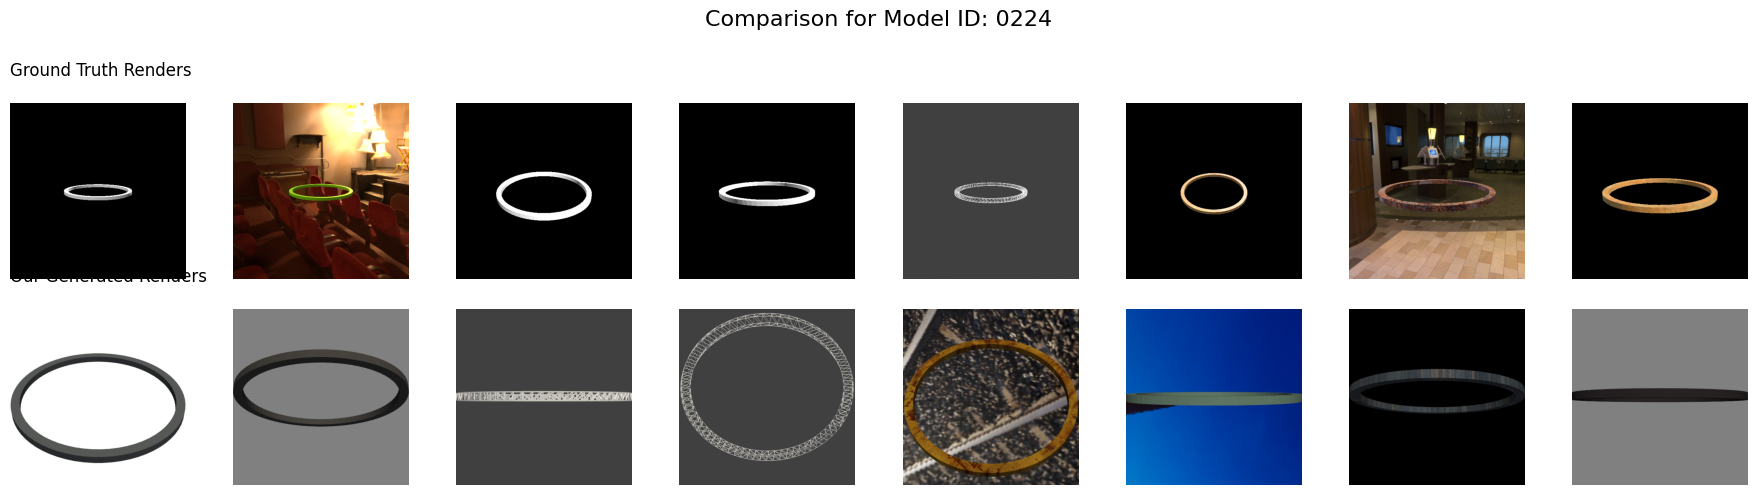

--------------------------------------------------
Processing model: 0265
  -> Found 26 ground truth images.
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0265.stl' normalized successfully.

Generating 26 random renders for 0265.stl...
  -> Saved comparison_renders/0265/0265_1_wireframe.png (width:2.4)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '18'
  -> Saved comparison_renders/0265/0265_2_pbr.png 
  -> Saved comparison_renders/0265/0265_3_orthographic.png 
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '23'
  -> Saved comparison_renders/0265/0265_4_pbr.png 
  -> Saved comparison_renders/0265/0265_5_wireframe.png (width:1.1)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '1'
  -> Saved comparison_renders/0265/0265_6_pbr.png 
Checking for archives to unpack 

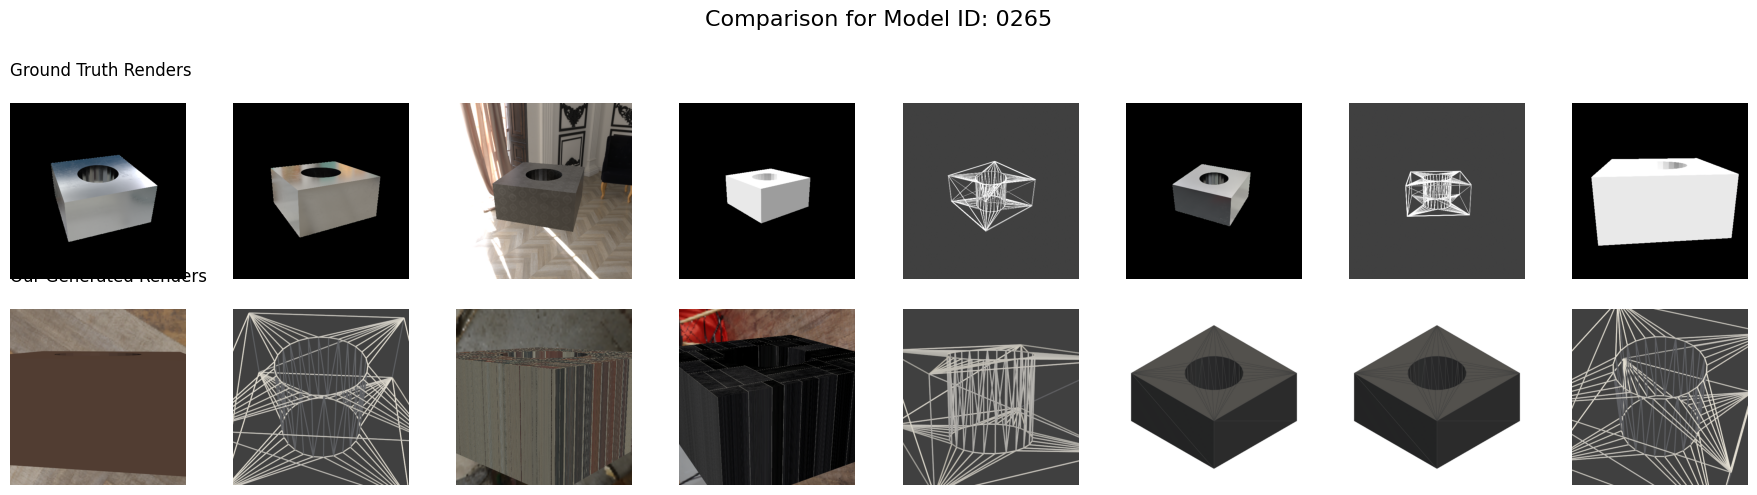

--------------------------------------------------
Processing model: 0388
  -> Found 26 ground truth images.
Renderer initialized. Available modes: ['pbr', 'pbr', 'pbr', 'wireframe', 'wireframe', 'orthographic']
Mesh '0388.stl' normalized successfully.

Generating 26 random renders for 0388.stl...
  -> Saved comparison_renders/0388/0388_1_wireframe.png (width:2.6)
  -> Saved comparison_renders/0388/0388_2_pbr.png 
  -> Saved comparison_renders/0388/0388_3_pbr.png 
  -> Saved comparison_renders/0388/0388_4_wireframe.png (width:2.5)
  -> Saved comparison_renders/0388/0388_5_pbr.png 
  -> Saved comparison_renders/0388/0388_6_pbr.png 
  -> Saved comparison_renders/0388/0388_7_wireframe.png (width:1.3)
  -> Saved comparison_renders/0388/0388_8_pbr.png 
  -> Saved comparison_renders/0388/0388_9_orthographic.png (opacity:0.55)
  -> Saved comparison_renders/0388/0388_10_wireframe.png (width:3.3)
  -> Saved comparison_renders/0388/0388_11_pbr.png 
  -> Saved comparison_renders/0388/0388_12_pbr.

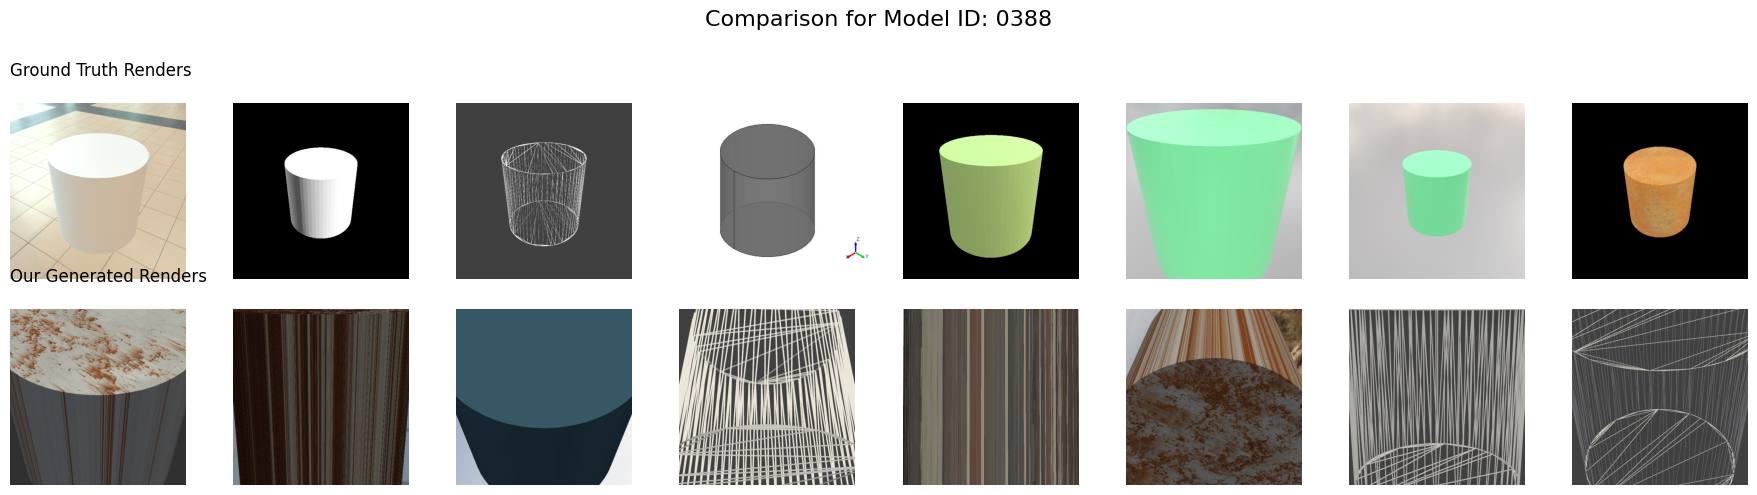

--------------------------------------------------
Comparison finished.


In [75]:


def visualize_comparison(model_id, ground_truth_paths, generated_paths, num_samples=8):
    """Displays a grid comparing ground truth and generated images."""
    
    sample_gt = random.sample(ground_truth_paths, min(num_samples, len(ground_truth_paths)))
    sample_gen = random.sample(generated_paths, min(num_samples, len(generated_paths)))

    fig, axes = plt.subplots(2, num_samples, figsize=(18, 5))
    fig.suptitle(f"Comparison for Model ID: {model_id}", fontsize=16)

    # Top row: Ground Truth
    for i, img_path in enumerate(sample_gt):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Ground Truth Renders", loc='left', fontsize=12, pad=20)

    # Bottom row: Our Generated Renders
    for i, img_path in enumerate(sample_gen):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Our Generated Renders", loc='left', fontsize=12, pad=20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    # --- Конфигурация ---
    NUM_MODELS_TO_COMPARE = 3
    NUM_RENDERS_PER_MODEL = 26
    RESOLUTION = (512, 512)
    
    # --- Пути к данным ---
    data_root = Path('data/train_data')
    images_root = data_root / 'images'
    models_root = data_root / 'models'

    # Временная папка для наших рендеров
    comparison_output_root = Path('comparison_renders')
    if comparison_output_root.exists():
        shutil.rmtree(comparison_output_root) # Очищаем старые результаты
    comparison_output_root.mkdir()

    # --- Инициализация рендерера ---
    # Убедитесь, что RENDER_CONFIG импортирован из вашего файла renderer.py
    # и содержит правильный путь к папке 'textures'
    if not Path(RENDER_CONFIG['textures_dir']).exists():
        Path(RENDER_CONFIG['textures_dir']).mkdir()
        print(f"Created textures directory at: {RENDER_CONFIG['textures_dir']}")
        
    renderer = STLRenderer(config=RENDER_CONFIG)

    # --- Основной цикл сравнения ---
    all_stl_files = list(models_root.glob('*.stl'))
    models_to_compare = random.sample(all_stl_files, min(NUM_MODELS_TO_COMPARE, len(all_stl_files)))

    for stl_path in models_to_compare:
        model_id = stl_path.stem
        print("-" * 50)
        print(f"Processing model: {model_id}")

        # 1. Находим эталонные рендеры
        ground_truth_images = list(images_root.glob(f'{model_id}_*.png'))
        if not ground_truth_images:
            print(f"  -> No ground truth images found for {model_id}. Skipping.")
            continue
        
        print(f"  -> Found {len(ground_truth_images)} ground truth images.")

        # 2. Генерируем наши рендеры
        model_render_dir = comparison_output_root / model_id
        
        # Модифицируем конфиг на лету, чтобы рендеры сохранялись в нужную папку
        temp_config = RENDER_CONFIG.copy()
        temp_config['output_dir'] = str(model_render_dir)
        
        # Создаем новый экземпляр рендерера с временным конфигом
        temp_renderer = STLRenderer(config=temp_config)
        temp_renderer.generate_random_renders(
            stl_path=str(stl_path),
            num_renders=NUM_RENDERS_PER_MODEL,
            resolution=RESOLUTION,
        )
        generated_images = list(model_render_dir.glob('*.png'))
        print(f"  -> Generated {len(generated_images)} new renders.")

        # 3. Визуализируем сравнение
        visualize_comparison(model_id, ground_truth_images, generated_images)

    print("-" * 50)
    print("Comparison finished.")